### Setup

In [1]:
!pip install pandas
!pip install numpy
!pip install gensim
!pip install keras
!pip install scikit-learn
!pip install tensorflow

In [34]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data

In [35]:
kaggle_data = pd.read_csv("https://raw.githubusercontent.com/lodi-m/u-integrity/main/data/normalized_scores/normalized_kaggle_essay_set.csv")
kaggle_data.head(5)

,Essay_id,Essay_set_id,Essay,rater1_domain1,rater2_domain1,domain1_score,normalized_score
0,1,1,dear local newspap think effect comput peopl g...,4.0,4.0,8.0,0.6
1,2,1,dear believ use comput benefit us mani way lik...,5.0,4.0,9.0,0.7
2,3,1,dear peopl use comput everyon agre benefit soc...,4.0,3.0,7.0,0.5
3,4,1,dear local newspap found mani expert say compu...,5.0,5.0,10.0,0.8
4,5,1,dear know comput posit effect people. comput c...,4.0,4.0,8.0,0.6


### LSTM model

In [88]:
from tensorflow.keras.optimizers import RMSprop
def get_lstm():
    # initializing an empty neural network model layer by layer in a sequential manner
    model = Sequential()
    
    model.add(LSTM(200, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 200], return_sequences=True))
    model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(50, dropout=0.4, recurrent_dropout=0.4))
    model.add(Dense(1, activation='relu'))

#     model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.compile(optimizer=RMSprop(learning_rate = 0.0009), loss=tf.keras.losses.MeanAbsolutePercentageError(), metrics=['mae'])
    model.summary()

    return model

### Word2Vec

In [37]:
def get_w2v(df, min_word_count, num_features, num_workers, max_distance, downsample):
  w2v = Word2Vec(workers=num_workers, vector_size=num_features, min_count=min_word_count, window=max_distance, sample=downsample)

  w2v.build_vocab(df, progress_per=progress_val)
  w2v.train(df, total_examples=w2v.corpus_count, epochs=w2v.epochs)

  return w2v

### Word embeddings

In [38]:
def make_feature_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features, ))
    index_keys = set(model.wv.index_to_key)
    
    for word in words:
      if word in index_keys:
        feature_vector = np.add(feature_vector, model.wv[word])
    return feature_vector

In [39]:
def avg_feature_vectors(essays, model, num_features):
    final_essay_vector = np.zeros((len(essays), num_features))
    
    for i in range(len(essays)):
        final_essay_vector[i] = make_feature_vectors(essays[i], model, num_features)
    return final_essay_vector

### Parameters

In [40]:
X = kaggle_data["Essay"]
y = kaggle_data["normalized_score"]

In [41]:
min_word_count = 8
num_features = 200
num_workers = 4
max_distance = 10
downsampling = 1e-3
progress_val = 2000

### Training LSTM

In [42]:
# mse_results = []
mae_results = []
mpe_results = []

In [43]:
w2v = get_w2v(X, min_word_count, num_features, num_workers, max_distance, downsampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clean_train_essays = X_train.to_list()
clean_test_essays = X_test.to_list()

train_vectors = avg_feature_vectors(clean_train_essays, w2v, num_features)
test_vectors = avg_feature_vectors(clean_test_essays, w2v, num_features)

train_vectors = np.array(train_vectors)
test_vectors = np.array(test_vectors)
  

In [44]:
from sklearn.preprocessing import MinMaxScaler
# Create scaler object
scaler = MinMaxScaler()

# Fit scaler to training data and transform it
train_vectors_scaled = scaler.fit_transform(train_vectors)
test_vectors_scaled = scaler.transform(test_vectors)
  
train_vectors_scaled = np.reshape(train_vectors_scaled, (train_vectors.shape[0], 1, train_vectors.shape[1]))
test_vectors_scaled = np.reshape(test_vectors_scaled, (test_vectors.shape[0], 1, test_vectors.shape[1]))

In [89]:
# fit modeland predict
lstm_model = get_lstm()
lstm_model.fit(train_vectors_scaled, y_train, batch_size=32, epochs=50)

y_pred = lstm_model.predict(test_vectors_scaled)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 1, 200)            320800    
                                                                 
 lstm_40 (LSTM)              (None, 1, 100)            120400    
                                                                 
 lstm_41 (LSTM)              (None, 50)                30200     
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 471,451
Trainable params: 471,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
129/129 [==============================] - 10s 15ms/step - loss: 675136.1250 - mae: 0.4857
Epoch 2/50
129/129 [==============================] - 2s 15ms/step - loss: 99

In [90]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
# mse = mean_squared_error(y_test, y_pred)
mpe = mape(y_test, y_pred).numpy()
mae = mean_absolute_error(y_test, y_pred)

# mse_results.append(mse)
mpe_results.append(mpe)
mae_results.append(mae)

In [91]:
np.around(np.array(mpe_results).mean(), decimals=4)

57146.316

In [92]:
np.around(np.array(mae_results).mean(), decimals=4)

0.5994

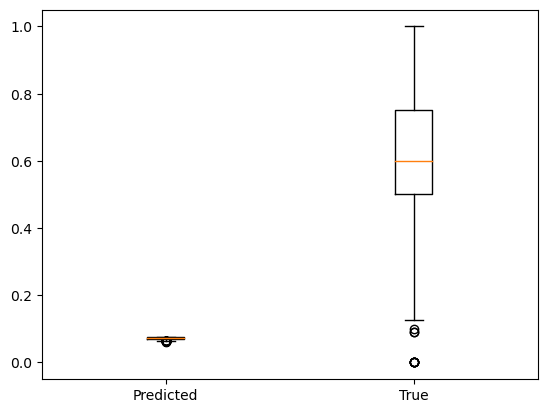

In [93]:
import matplotlib.pyplot as plt

# Create box plot of predicted and true values
data = [y_pred.flatten(), y_test.values.flatten()]
plt.boxplot(data, labels=['Predicted', 'True'])
plt.show()